The text component of the additional time embeddings are different locally and on cloud.

Therefore, I want to understand in detail how they are produced.

In [13]:
import torch
from torch.testing import assert_close
from torch import allclose, nn, tensor
torch.set_printoptions(linewidth=200)

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'mps'
device_dtype = torch.float16 if device == 'cuda' else torch.float32

## Load the model

In [15]:
from diffusers import StableDiffusionXLPipeline
from diffusers import EulerDiscreteScheduler
from diffusers.models.controlnetxs import ControlNetXSModel
from diffusers.pipelines.controlnet_xs.pipeline_controlnet_xs_sd_xl import StableDiffusionXLControlNetXSPipeline

In [16]:
sdxl_pipe = StableDiffusionXLPipeline.from_single_file('weights/sdxl/sd_xl_base_1.0_0.9vae.safetensors').to(device)
cnxs = ControlNetXSModel.from_pretrained('weights/cnxs').to(device)

At the end of __init__, the sigmas are tensor([14.6146, 14.5263, 14.4386, 14.3515, 14.2651]) ...
At the end of __init__, the sigmas are tensor([14.6146, 14.5263, 14.4386, 14.3515, 14.2651]) ...


In [17]:
cnxs.base_model = sdxl_pipe.unet

The example script of Heidelberg manually sets scale_list to 0.95

In [18]:
cnxs.scale_list = cnxs.scale_list * 0. + 0.95
assert cnxs.scale_list[0] == .95

Heidelberg uses `timestep_spacing = 'linspace'` in their scheduler, so let's do that as well

In [19]:
scheduler_cgf = dict(sdxl_pipe.scheduler.config)
scheduler_cgf['timestep_spacing'] = 'linspace'
sdxl_pipe.scheduler = EulerDiscreteScheduler.from_config(scheduler_cgf)

# test it worked
sdxl_pipe.scheduler.set_timesteps(50)
assert sdxl_pipe.scheduler.timesteps[0]==999

# reset
sdxl_pipe.scheduler = EulerDiscreteScheduler.from_config(scheduler_cgf)

At the end of __init__, the sigmas are tensor([14.6146, 14.5263, 14.4386, 14.3515, 14.2651]) ...
timestep_spacing = "leading" and timesteps=[999.      978.61224 958.2245  937.83673 917.449  ] ...
sigmas before interpolation: [0.02916753 0.04131448 0.05068044 0.05861427 0.06563709] ...
sigmas after (linear) interpolation: [14.61464691 12.93677721 11.49164976 10.24291444  9.16035419] ...
At end of `set_timesteps`:
sigmas =  tensor([14.6146, 12.9368, 11.4916, 10.2429,  9.1604]) ...
timesteps = tensor([999.0000, 978.6122, 958.2245, 937.8367, 917.4490]) ...
At the end of __init__, the sigmas are tensor([14.6146, 14.5263, 14.4386, 14.3515, 14.2651]) ...


In [20]:
cnxs_pipe = StableDiffusionXLControlNetXSPipeline(
    vae=sdxl_pipe.vae,
    text_encoder=sdxl_pipe.text_encoder,
    text_encoder_2=sdxl_pipe.text_encoder_2,
    tokenizer=sdxl_pipe.tokenizer,
    tokenizer_2=sdxl_pipe.tokenizer_2,
    unet=sdxl_pipe.unet,
    controlnet=cnxs,
    scheduler=sdxl_pipe.scheduler,
)

## Manually encode prompt

In [63]:
from util import cls_name

In [21]:
prompt = 'cinematic, shoe in the streets, made from meat, photorealistic shoe, highly detailed'
num_images_per_prompt = 1
do_classifier_free_guidance = True
negative_prompt = 'lowres, bad anatomy, worst quality, low quality'

In [70]:
from diffusers.loaders import FromSingleFileMixin, StableDiffusionXLLoraLoaderMixin, TextualInversionLoaderMixin

def encode_prompt(
    prompt: str,
    num_images_per_prompt = 1,
    do_classifier_free_guidance = True,
):
    self = cnxs_pipe
    
    # I'm ignoring negative prompting
    prompt_embeds = None
    pooled_prompt_embeds = None
    prompt_2 = prompt

    tokenizers = [self.tokenizer, self.tokenizer_2]
    text_encoders = [self.text_encoder, self.text_encoder_2]
        
    # textual inversion: procecss multi-vector tokens if necessary
    prompt_embeds_list = []
    prompts = [prompt, prompt_2]
    
    for prompt, tokenizer, text_encoder in zip(prompts, tokenizers, text_encoders):
        if isinstance(self, TextualInversionLoaderMixin):
            print('I\'m something of a TextualInversionLoaderMixin myself')
            prompt = self.maybe_convert_prompt(prompt, tokenizer)

        text_inputs = tokenizer(prompt,padding="max_length",max_length=tokenizer.model_max_length,truncation=True,return_tensors="pt")

        text_input_ids = text_inputs.input_ids
        untruncated_ids = tokenizer(prompt, padding="longest", return_tensors="pt").input_ids

        if untruncated_ids.shape[-1] >= text_input_ids.shape[-1] and not torch.equal(text_input_ids, untruncated_ids):
            print('Bro, your long-ass prompt got truncated') 

        prompt_embeds = text_encoder(text_input_ids.to(device),output_hidden_states=True,)
        
        # We are only ALWAYS interested in the pooled output of the final text encoder
        pooled_prompt_embeds = prompt_embeds[0]
        prompt_embeds = prompt_embeds.hidden_states[-2]

        prompt_embeds_list.append(prompt_embeds)

    prompt_embeds = torch.concat(prompt_embeds_list, dim=-1)

    prompt_embeds = prompt_embeds.to(dtype=self.text_encoder_2.dtype, device=device)
    bs_embed, seq_len, _ = prompt_embeds.shape
    # duplicate text embeddings for each generation per prompt, using mps friendly method
    prompt_embeds = prompt_embeds.repeat(1, num_images_per_prompt, 1)
    prompt_embeds = prompt_embeds.view(bs_embed * num_images_per_prompt, seq_len, -1)

    pooled_prompt_embeds = pooled_prompt_embeds.repeat(1, num_images_per_prompt).view(
        bs_embed * num_images_per_prompt, -1
    )

    return prompt_embeds, pooled_prompt_embeds, text_input_ids

In [71]:
prompt_embeds, pooled_prompt_embeds, text_input_ids = encode_prompt(
    'a'.join(' ' for _ in range(200)), # prompt,
    num_images_per_prompt,
    do_classifier_free_guidance,
)

I'm something of a TextualInversionLoaderMixin myself
Bro, your long-ass prompt got truncated
I'm something of a TextualInversionLoaderMixin myself
Bro, your long-ass prompt got truncated


In [72]:
prompt_embeds.shape, pooled_prompt_embeds.shape

(torch.Size([1, 77, 2048]), torch.Size([1, 1280]))

In [77]:
clip1_outp = cnxs_pipe.text_encoder  (text_input_ids.to(device),output_hidden_states=True)
clip2_outp = cnxs_pipe.text_encoder_2(text_input_ids.to(device),output_hidden_states=True)

In [78]:
clip1_outp.last_hidden_state.shape

torch.Size([1, 77, 768])

In [76]:
clip2_outp.last_hidden_state.shape

torch.Size([1, 77, 1280])

In [81]:
clip2_outp[0].shape

torch.Size([1, 1280])

In [82]:
clip2_outp.keys()

odict_keys(['text_embeds', 'last_hidden_state', 'hidden_states'])

In [96]:
def tokenize(prompt,tokenizer): return tokenizer(prompt,padding="max_length",max_length=tokenizer.model_max_length,truncation=True,return_tensors="pt").input_ids

In [98]:
tokenize(prompt,cnxs_pipe.tokenizer)

tensor([[49406, 25602,   267,  7342,   530,   518,  6058,   267,  1105,   633,  6480,   267,  1153, 16157,  7342,   267,  5302, 12609, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407,
         49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407, 49407]])

In [105]:
toks_l = tokenize(prompt,cnxs_pipe.tokenizer_2)[0]
print(len(toks_l))
toks_l

77


tensor([49406, 25602,   267,  7342,   530,   518,  6058,   267,  1105,   633,  6480,   267,  1153, 16157,  7342,   267,  5302, 12609, 49407,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0,     0])

In [106]:
(tokenize(prompt,cnxs_pipe.tokenizer) == tokenize(prompt,cnxs_pipe.tokenizer_2)).all()

tensor(False)

In [131]:
toks_c = torch.tensor([
    49406, 25602,   267,  7342,   530,   518,  6058,   267,  1105,   633,
    6480,   267,  1153, 16157,  7342,   267,  5302, 12609, 49407,     0,
        0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
        0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
        0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
        0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
        0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
        0,     0,     0,     0,     0,     0,     0
])
len(toks_c)

77

In [132]:
len(toks_c)==len(toks_l)

True

In [135]:
(toks_c==toks_l).all()

tensor(True)

The prompt is equal on cloud/local and is tokenized into the same tokens

If the text_encoder is the same, the encoding should be equal as well

In [116]:
txt_emb_c = torch.load('intermediate_output/temb/cloud/encoder2_pooled', map_location='mps')
txt_emb_c.shape

torch.Size([1, 1280])

In [117]:
txt_emb_l = clip2_outp[0]
txt_emb_l.shape

torch.Size([1, 1280])

In [118]:
txt_emb_c==txt_emb_l

tensor([[False, False, False,  ..., False, False, False]], device='mps:0')

In [119]:
from util_plot import visually_compare_1d

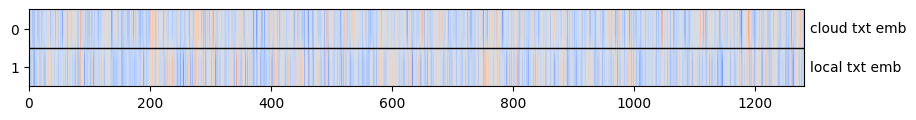

In [126]:
visually_compare_1d(txt_emb_c, txt_emb_l, ('cloud txt emb','local txt emb'), joint=True)

The encoding is different. Therefore, **the encoders seem to be different!**